# Modified ILC weights for bias and noise reduction

In [1]:
# imports

from __future__ import print_function
from __future__ import division
from builtins import map
import universe
from universe import *

import halo_fit
from halo_fit import *

import weight
from weight import *


import pn_2d
from pn_2d import *

import cmb
from cmb import *

import flat_map
from flat_map import *

import pandas as pd

import cmb_ilc
from cmb_ilc import *

import scipy

from headers import*

from SO_noise2 import*

from scipy.interpolate import interp1d

In [2]:
##################################################################################
# make plots prettier
import matplotlib
from matplotlib.pyplot import rc
import matplotlib.font_manager

rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})

matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25
matplotlib.rcParams['legend.fontsize'] = 25
#matplotlib.rcParams['legend.title_fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.width'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Setup

In [3]:
# Specifications
Nu = np.array([27.e9,39.e9,93.e9,145.e9,225.e9,280.e9]) # [Hz]
Beam = np.array([7.4,5.1,2.2,1.4,1.0,0.9])
#Noise = np.array([71., 36., 8., 10., 22., 54.])  # [muK*arcmin]
Noise = np.array([52.,27.,5.8,6.3,15.,37.])
#Noise = np.array([71.,36.,8.,10.,22.,54.])

# init

cmbIlc = CMBILC(Nu, Beam, Noise, atm=True)

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/Berkeley/LensQuEst-1/cmb.py:127: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:135: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:149: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl


In [4]:
lMin = 10.
lMax = 1500.

LMin = 20.
LMax = 1.e3

nBands = 6
nBins = 21

octantArea = 4.*np.pi * (180./np.pi)**2   # deg 2
octantArea /= 8.
ourArea = 81. * 20.**2  # deg 2
uncertaintyFactor = np.sqrt(ourArea / octantArea)

data = pd.read_csv('output/mean_biases.csv')
data2 = pd.read_csv('output/Ckk_biases_lmaxT_3500.csv')
lCen = np.array(data['lCen'])
I = np.where((lCen>=LMin)*(lCen<=LMax))
lEdges = np.logspace(np.log10(1.), np.log10(np.max(15273.50)), nBins, 10.) # Edges of the bins
Nmodes = np.array(data2['Nmodes'])

In [5]:
nX = 400
nY = 400
size = 10.  # degrees, determined by the Sehgal cutouts
baseMap = FlatMap(nX=nX, nY=nY, sizeX=size*np.pi/180., sizeY=size*np.pi/180.)

In [6]:
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
w_lsstgold = WeightTracerLSSTGold(u)
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)
ClkCmb = p2d_cmblens.fPinterp(lCen)

p2d_lsstgold = P2dAuto(u, halofit, w_lsstgold, fPnoise=lambda l:1./w_lsstgold.ngal, nProc=3, save=True)
p2d_lsstgoldcmblens = P2dCross(u, halofit, w_lsstgold, w_cmblens, nProc=3, save=True)
Ckg = p2d_lsstgoldcmblens.fPtotinterp(lCen)
Cgg = p2d_lsstgold.fPtotinterp(lCen)

L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 501, 10.)

weightsIlcCmb = np.array([cmbIlc.weightsIlcCmb(l) for l in L])

weightsIlcCmb_jointDeproj = np.array([cmbIlc.weightsDeprojTszCIB(l) for l in L])

weightsIlcCmb_tszdeproj = np.array([cmbIlc.weightsDeprojTsz(l) for l in L])

weightsIlcCmb_cibdeproj = np.array([cmbIlc.weightsDeprojCIB(l) for l in L])

In [7]:
def ctot(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def ctot_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def ctot_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def ctot_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [8]:
fCtotal = np.array([ctot(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
fCtotal_deproj = np.array([ctot_deproj(l,lindex) for lindex,l in enumerate(L)])
fCtotal_tszdeproj = np.array([ctot_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCtotal_cibdeproj = np.array([ctot_cibdeproj(l,lindex) for lindex,l in enumerate(L)])

In [9]:
def cTsz(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def cTsz_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def cTsz_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def cTsz_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [10]:
fCTsz = np.array([cTsz(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
fCTsz_deproj = np.array([cTsz_deproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz_tszdeproj = np.array([cTsz_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz_cibdeproj = np.array([cTsz_cibdeproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz148 = np.array([cmbIlc.cmb[3,3].ftSZ(l) for l in L])

In [11]:
def cCIB(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def cCIB_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def cCIB_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def cCIB_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [12]:
fCCIB = np.array([cCIB(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
fCCIB_deproj = np.array([cCIB_deproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB_tszdeproj = np.array([cCIB_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB_cibdeproj = np.array([cCIB_cibdeproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB148 = np.array([cmbIlc.cmb[3,3].fCIB(l) for l in L])

# Figure 1.

Text(0, 0.5, '$C_\\ell/C^\\text{150 GHz}_\\ell$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


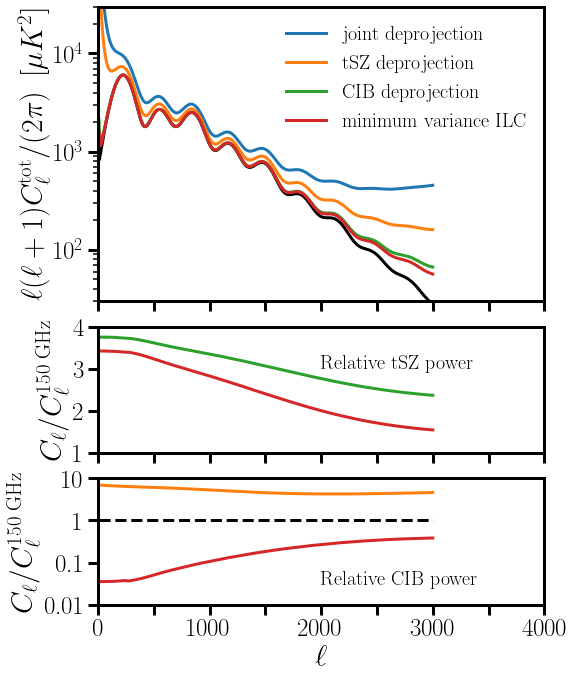

In [13]:
fig,ax = plt.subplots(3,1,figsize=(8,11),sharex=True,gridspec_kw={'height_ratios':[0.7,0.3,0.3],'hspace':0.14})

signal = np.array([cmbIlc.cmb[0,0].flensedTT(l) for l in L])

ax[0].semilogy(L,signal*L*(L+1)/(2.*np.pi),color='k',lw=3)

ax[0].semilogy(L,fCtotal_deproj*L*(L+1.)/(2.*np.pi),color='C0',label='joint deprojection',lw=3)
ax[0].semilogy(L,fCtotal_tszdeproj*L*(L+1.)/(2.*np.pi),color='C1',label='tSZ deprojection',lw=3)
ax[0].semilogy(L,fCtotal_cibdeproj*L*(L+1.)/(2.*np.pi),color='C2',label='CIB deprojection',lw=3)
ax[0].semilogy(L,fCtotal*L*(L+1.)/(2.*np.pi),color='C3',label='minimum variance ILC',lw=3)

ax[1].plot(L,fCTsz_cibdeproj/fCTsz148,color='C2',lw=3,label='CIB deprojection')
ax[1].plot(L,fCTsz/fCTsz148,color='C3',lw=3,label='minimum variance ILC')
ax[1].plot(L,np.ones(L.shape),c='k',lw=3,label='148 GHz',ls='--')

ax[2].semilogy(L,fCCIB_tszdeproj/fCCIB148,color='C1',label='tSZ deprojection',lw=3)
ax[2].semilogy(L,fCCIB/fCCIB148,color='C3',label='minimum variance ILC',lw=3)
ax[2].plot(L,np.ones(L.shape),c='k',lw=3,label='148 GHz',ls='--')


ax[0].set_xlim(0,4000)
ax[0].set_ylim(30,3e4)

ax[2].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\ell(\ell+1)C^\text{tot}_\ell/(2\pi)\,\,\,[\mu K^2]$')
ax[0].legend(loc=0,frameon=False,fontsize=20)
#ax[1].legend(loc=0,frameon=False,fontsize=20)
#ax[2].legend(loc=0,frameon=False,fontsize=20)

ax[1].set_yticks([1,2,3,4])
ax[1].set_ylim(1,4)

ax[2].set_yticks([10,1,0.1,0.01])
ax[2].set_yticklabels([10,1,0.1,0.01])
ax[2].set_ylim(0.01,10)

ax[2].set_xticks([0,500,1000,1500,2000,2500,3000,3500,4000])
ax[2].set_xticklabels([0,'',1000,'',2000,'',3000,'',4000])

ax[1].text(2000,3,r'Relative tSZ power',fontsize=20)
ax[2].text(2000,3e-2,r'Relative CIB power',fontsize=20)

ax[1].set_ylabel(r'$C_\ell/C^\text{150 GHz}_\ell$')
ax[2].set_ylabel(r'$C_\ell/C^\text{150 GHz}_\ell$')

#plt.savefig('figures/ILC_noises.pdf',bbox_inches='tight')

# Figure 2.

## Calculating noises

In [14]:
fCtotal = np.array([ctot(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1839: RuntimeWarning: divide by zero encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)


In [15]:
fCtotal = np.array([ctot_deproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_deproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


In [16]:
fCtotal = np.array([ctot_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_tszdeproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


In [17]:
fCtotal = np.array([ctot_cibdeproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_cibdeproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


## loading biases

In [18]:
N = 81

octantArea = 4.*np.pi * (180./np.pi)**2   # deg 2
octantArea /= 8.
ourArea = N * 20.**2  # deg 2
uncertaintyFactor = np.sqrt(ourArea / octantArea)

def get_data(name,t,i):
    path = name + '/' + str(int(lMax)) + '/' + "output_t_"+"{0:0=2d}".format(int(t*10)) 
    dataAvg = np.genfromtxt(path+'/data_lmaxT_'+str(int(lMax))+'_'+str(i)+'.txt')
    i=0
    # All extragalactic foregrounds (scale dep)
    # 
    # Trispectrum
    ClqCmbAllScaleDep = dataAvg[int(0+16*i)]
    ClsCmbAllScaleDep = dataAvg[int(1+16*i)]
    ClBHCmbAllScaleDep = dataAvg[int(2+16*i)]
    ClBHPCmbAllScaleDep = dataAvg[int(3+16*i)]
    # Primary
    ClqCmbAllScaleDepKappa = dataAvg[int(4+16*i)]
    ClsCmbAllScaleDepKappa = dataAvg[int(5+16*i)]
    ClBHCmbAllScaleDepKappa = dataAvg[int(6+16*i)]
    ClBHPCmbAllScaleDepKappa = dataAvg[int(7+16*i)]
    # k_rec x LSST 
    ClqCmbAllScaleDepLsstgold = dataAvg[int(8+16*i)]
    ClsCmbAllScaleDepLsstgold = dataAvg[int(9+16*i)]
    ClBHCmbAllScaleDepLsstgold = dataAvg[int(10+16*i)]
    ClBHPCmbAllScaleDepLsstgold = dataAvg[int(11+16*i)]
    # Secondary
    ClqCmbAllScaleDepSec = dataAvg[int(12+16*i)]
    ClsCmbAllScaleDepSec = dataAvg[int(13+16*i)]
    ClBHCmbAllScaleDepSec = dataAvg[int(14+16*i)]
    ClBHPCmbAllScaleDepSec = dataAvg[int(15+16*i)]
    
    bias_list = np.array([ 
    ClqCmbAllScaleDepKappa*2/ClkCmb,
    ClBHCmbAllScaleDepKappa*2/ClkCmb,
    ClBHPCmbAllScaleDepKappa*2/ClkCmb,
    ClsCmbAllScaleDepKappa*2/ClkCmb,
    ClqCmbAllScaleDepSec*2/ClkCmb,
    ClBHCmbAllScaleDepSec*2/ClkCmb,
    ClBHPCmbAllScaleDepSec*2/ClkCmb,
    ClsCmbAllScaleDepSec*2/ClkCmb,
    ClqCmbAllScaleDep/ClkCmb,
    ClBHCmbAllScaleDep/ClkCmb,
    ClBHPCmbAllScaleDep/ClkCmb,
    ClsCmbAllScaleDep/ClkCmb,
    #
    ClqCmbAllScaleDepLsstgold/Ckg,
    ClBHCmbAllScaleDepLsstgold/Ckg,
    ClBHPCmbAllScaleDepLsstgold/Ckg,
    ClsCmbAllScaleDepLsstgold/Ckg])
    
    return bias_list

def QE_bias_L(name,t):
    bias_list = np.array([get_data(name,t,i) for i in range(N)])
    QE_biases = np.array([b[0]+b[4]+b[8] for b in bias_list])
    mean = np.mean(QE_biases,axis=0)
    std = np.std(QE_biases,axis=0)*uncertaintyFactor/np.sqrt(N)
    return mean, std

def all_estimators_bias_L(name,t):
    bias_list = np.array([get_data(name,t,i) for i in range(N)])
    QE_biases = np.array([b[0]+b[4]+b[8] for b in bias_list])
    PSH_biases = np.array([b[1]+b[5]+b[9] for b in bias_list])
    PH_biases = np.array([b[2]+b[6]+b[10] for b in bias_list])
    Shear_biases = np.array([b[3]+b[7]+b[11] for b in bias_list])
    return QE_biases, PSH_biases, PH_biases, Shear_biases

def all_estimators_cross_bias_L(name,t):
    bias_list = np.array([get_data(name,t,i) for i in range(N)])
    QE_biases = np.array([b[12] for b in bias_list])
    PSH_biases = np.array([b[13] for b in bias_list])
    PH_biases = np.array([b[14] for b in bias_list])
    Shear_biases = np.array([b[15] for b in bias_list])
    return QE_biases, PSH_biases, PH_biases, Shear_biases

# Figure 3.

In [19]:
tmp_ells = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
for i in range(6):
   for j in range(6):
      forCtot = np.array([cmbIlc.cmb[i,j].ftotalTT(l) for l in tmp_ells])
      cmbIlc.cmb[i,j].ftotalTT = interp1d(tmp_ells,forCtot)

In [20]:
tmp_ells = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
wILCTrue = np.array([cmbIlc.weightsIlcCmb(l) for l in tmp_ells]).T
wILCTrue_interp = np.array([interp1d(tmp_ells,wILCTrue[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

wJointDeproj = np.array([cmbIlc.weightsDeprojTszCIB(l) for l in tmp_ells]).T
wJointDeproj_interp = np.array([interp1d(tmp_ells,wJointDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

wCIBDeproj = np.array([cmbIlc.weightsDeprojCIB(l) for l in tmp_ells]).T
wCIBDeproj_interp = np.array([interp1d(tmp_ells,wCIBDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

wTszDeproj = np.array([cmbIlc.weightsDeprojTsz(l) for l in tmp_ells]).T
wTszDeproj_interp = np.array([interp1d(tmp_ells,wTszDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

def wILC_interp(t,u,v,l,i): return wILCTrue_interp[i](l) + t*(wJointDeproj_interp[i](l)-wILCTrue_interp[i](l))+ u*(wCIBDeproj_interp[i](l)-wILCTrue_interp[i](l))+ v*(wTszDeproj_interp[i](l)-wILCTrue_interp[i](l))

def ctot(t,u,v,l):
  result = 0
  for i in range(len(Nu)):
     for j in range(len(Nu)):
        result += cmbIlc.cmb[i,j].ftotalTT(l)*wILC_interp(t,u,v,l,i)*wILC_interp(t,u,v,l,j)
  return result

def ctot_interp(t,u,v):
   L = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
   forCtot = np.array([ctot(t,u,v,l) for l in L])
   fCtotal = interp1d(L, forCtot, kind='linear', bounds_error=False, fill_value=np.inf)
   return fCtotal

def ctSZCIB(t,u,v,l):
  result = 0
  for i in range(len(Nu)):
     for j in range(len(Nu)):
        result += (cmbIlc.cmb[i,j].ftSZ(l)+cmbIlc.cmb[i,j].fCIB(l)+cmbIlc.cmb[i,j].ftSZ_CIB(l))*wILC_interp(t,u,v,l,i)*wILC_interp(t,u,v,l,j)
  return result

def ctSZCIB_interp(t,u,v):
   L = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
   forCtot = np.array([ctSZCIB(t,u,v,l) for l in L])
   fCtotal = interp1d(L, forCtot, kind='linear', bounds_error=False, fill_value=np.inf)
   return fCtotal

In [21]:
l = np.genfromtxt('l.txt')
profile = np.genfromtxt('profile.txt')
uTsz = interp1d(l,profile,kind='linear')

def get_noises(t,u,v):
   fCtotal = ctot_interp(t,u,v)
   fNqCmb_fft = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False)(lCen)
   fNsCmb_fft = baseMap.forecastN0KappaShear(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, corr=True, test=False)(lCen)
   fNqBHCmb_fft = baseMap.forecastN0KappaBH(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False)(lCen)
   fNqBHPCmb_fft = baseMap.forecastN0KappaBH(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False, u=uTsz)(lCen)
   return fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft

In [22]:
def Alens_biases_ILC_to_Joint(t):
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(t,0,0)
   QE_biases, PSH_biases, PH_biases, Shear_biases = all_estimators_bias_L('ILC_to_Joint',t)
   QE_biasesx, PSH_biasesx, PH_biasesx, Shear_biasesx = all_estimators_cross_bias_L('ILC_to_Joint',t)
        
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasq in QE_biases ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * ClkCmb[I]**2 / s2[I])) / norm for biasq in QE_biases ])
   QE_mean = np.mean(QE_bs)
   QE_std = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2 = np.mean(QE_bs2)
   QE_std2 = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noise = np.sqrt(noise)
   #
   # QE cross 
   s2 = ((ClkCmb + fNqCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise = 1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * Ckg[I]**2 / s2[I]) / norm for biasq in QE_biasesx ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * Ckg[I]**2 / s2[I])) / norm for biasq in QE_biasesx ])
   QE_meanx = np.mean(QE_bs)
   QE_stdx = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2x = np.mean(QE_bs2)
   QE_std2x = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noisex = np.sqrt(noise)
   
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm for biass in Shear_biases ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * ClkCmb[I]**2 / s2[I])) / norm for biass in Shear_biases ])
   Shear_mean = np.mean(Shear_bs)
   Shear_std = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2 = np.mean(Shear_bs2)
   Shear_std2 = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noise = np.sqrt(noise)
   #
   # Shear cross
   s2 = ((ClkCmb + fNsCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4) 
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * Ckg[I]**2 / s2[I]) / norm for biass in Shear_biasesx ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * Ckg[I]**2 / s2[I])) / norm for biass in Shear_biasesx ])
   Shear_meanx = np.mean(Shear_bs)
   Shear_stdx = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2x = np.mean(Shear_bs2)
   Shear_std2x = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noisex = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbh in PSH_biases ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbh in PSH_biases ])
   PSH_mean = np.mean(PSH_bs)
   PSH_std = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2 = np.mean(PSH_bs2)
   PSH_std2 = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noise = np.sqrt(noise)
   #
   # PSH cross
   s2 = ((ClkCmb + fNqBHCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * Ckg[I]**2 / s2[I]) / norm for biasbh in PSH_biasesx ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * Ckg[I]**2 / s2[I])) / norm for biasbh in PSH_biasesx ])
   PSH_meanx = np.mean(PSH_bs)
   PSH_stdx = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2x = np.mean(PSH_bs2)
   PSH_std2x = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noisex = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbhp in PH_biases ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbhp in PH_biases ])
   PH_mean = np.mean(PH_bs)
   PH_std = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2 = np.mean(PH_bs2)
   PH_std2 = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noise = np.sqrt(noise)
   #
   # PH cross
   s2 = ((ClkCmb + fNqBHPCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * Ckg[I]**2 / s2[I]) / norm for biasbhp in PH_biasesx ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * Ckg[I]**2 / s2[I])) / norm for biasbhp in PH_biasesx ])
   PH_meanx = np.mean(PH_bs)
   PH_stdx = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2x = np.mean(PH_bs2)
   PH_std2x = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noisex = np.sqrt(noise)

   mean = np.array([QE_mean, Shear_mean, PSH_mean, PH_mean])
   std = np.array([QE_std, Shear_std, PSH_std, PH_std])
   mean2 = np.array([QE_mean2, Shear_mean2, PSH_mean2, PH_mean2])
   std2 = np.array([QE_std2, Shear_std2, PSH_std2, PH_std2])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   meanx = np.array([QE_meanx, Shear_meanx, PSH_meanx, PH_meanx])
   stdx = np.array([QE_stdx, Shear_stdx, PSH_stdx, PH_stdx])
   mean2x = np.array([QE_mean2x, Shear_mean2x, PSH_mean2x, PH_mean2x])
   std2x = np.array([QE_std2x, Shear_std2x, PSH_std2x, PH_std2x])
   noisesx = np.array([QE_noisex,Shear_noisex,PSH_noisex,PH_noisex])

   return mean, std, noises, mean2, std2, meanx, stdx, noisesx, mean2x, std2x

In [23]:
mean_00, std_00, noises_00, mean2_00, std2_00, meanx_00, stdx_00, noisesx_00, mean2x_00, std2x_00 = Alens_biases_ILC_to_Joint(0)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3365: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l) * fCfg(l)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3393: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: fCfg(l) * (l>=lMin) * (l<=lMax)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3397: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l)**2 * fCfg(l)


doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4637: RuntimeWarning: invalid value encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)


computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT


In [24]:
dat = np.array([mean_00, std_00, noises_00, mean2_00, std2_00, meanx_00, stdx_00, noisesx_00, mean2x_00, std2x_00])
np.savetxt('output/ILC_lmaxT_'+str(int(lMax))+'.txt',dat)